# Create your variational autoencoder using convolutional layers.

## Import necesssary library

In [1]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary

## Define the device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Define the DataLoader for training and validation datasets

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Constants
VAL_SIZE = 0.2
BATCH_SIZE = 64

# Generate indices for train-validation split
train_indices, val_indices, _, _ = train_test_split(
    range(len(mnist_train)),
    mnist_train.targets,
    stratify=mnist_train.targets,
    test_size=VAL_SIZE,
)

# Generate Subset based on indices
train_split = Subset(mnist_train, train_indices)
val_split = Subset(mnist_train, val_indices)

# Create DataLoaders
Tr_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
Va_dataloader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
Ts_dataloader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 241539501.09it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108447353.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 88991576.76it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10601295.92it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Define the Variational Autoencoder

In [4]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, 32)
        self.fc_logvar = nn.Linear(64 * 7 * 7, 32)

        self.decoder = nn.Sequential(
            nn.Linear(32, 64 * 7 * 7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.to(torch.float32)  # Convert input to float32
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

## Define the training function

In [5]:
def train_VAE(model, dataloaders, criterion, optimizer, num_epochs=10):
    start = time.time()

    va_loss_history = []
    tr_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = np.inf

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = dataloaders['train']
            else:
                model.eval()
                dataloader = dataloaders['val']

            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, mu, logvar = model(inputs)
                    loss = criterion(outputs, inputs, mu, logvar)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            if phase == 'val' and epoch_loss < best_val:
                best_val = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            # Store the loss values correctly
            if phase == 'val':
                va_loss_history.append(epoch_loss)
            if phase == 'train':
                tr_loss_history.append(epoch_loss)  # Append the current loss to the list

        epoch_end = time.time()
        elapsed_epoch = epoch_end - epoch_start
        print("Epoch time taken: {:.0f}m {:.0f}s".format(elapsed_epoch // 60, elapsed_epoch % 60))
        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validate Loss: {:.4f}'.format(best_val))
    model.load_state_dict(best_model_wts)
    return model, tr_loss_history, va_loss_history

## Move model to target device (GPU)

In [6]:
model = VariationalAutoencoder().to(device)
print(model)
summary(model, input_size=(1, 28, 28))  # Assuming MNIST images are 28x28 pixels

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=3136, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output

## Define the criterion and optimizer

In [7]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, recon_x, x, mu, logvar):
        # Denormalize the inputs to [0, 1]
        x = (x + 1) / 2
        recon_x = (recon_x + 1) / 2

        # Calculate BCELoss
        bce_loss = nn.BCELoss(reduction='sum')(recon_x, x)

        # Calculate KLDLoss
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return bce_loss + kld_loss

criterion = VAELoss()
params_to_update = model.parameters()
optimizer = optim.Adam(params_to_update, lr=0.001)

## Train the model

In [8]:
model, tr_loss_history, va_loss_history = train_VAE(model, {"train": Tr_dataloader, "val": Va_dataloader}, criterion, optimizer)

Epoch 0/9
----------
train Loss: 35814.6909
val Loss: 34961.5464
Epoch time taken: 0m 18s

Epoch 1/9
----------
train Loss: 34933.1798
val Loss: 34792.2564
Epoch time taken: 0m 17s

Epoch 2/9
----------
train Loss: 34805.1226
val Loss: 34734.5674
Epoch time taken: 0m 17s

Epoch 3/9
----------
train Loss: 34779.8354
val Loss: 34733.1651
Epoch time taken: 0m 17s

Epoch 4/9
----------
train Loss: 34779.4788
val Loss: 34733.0652
Epoch time taken: 0m 17s

Epoch 5/9
----------
train Loss: 34779.4170
val Loss: 34733.0291
Epoch time taken: 0m 17s

Epoch 6/9
----------
train Loss: 34779.3907
val Loss: 34733.0110
Epoch time taken: 0m 17s

Epoch 7/9
----------
train Loss: 34779.3788
val Loss: 34733.0029
Epoch time taken: 0m 18s

Epoch 8/9
----------
train Loss: 34779.3711
val Loss: 34732.9952
Epoch time taken: 0m 17s

Epoch 9/9
----------
train Loss: 34779.3672
val Loss: 34732.9934
Epoch time taken: 0m 16s

Training complete in 2m 51s
Best Validate Loss: 34732.9934


## Move tensors to CPU before plotting

In [9]:
tr_loss_history_cpu = [item.cpu().detach().numpy() if isinstance(item, torch.Tensor) else item for item in tr_loss_history]
va_loss_history_cpu = [item.cpu().detach().numpy() if isinstance(item, torch.Tensor) else item for item in va_loss_history]

## Plot the loss curves

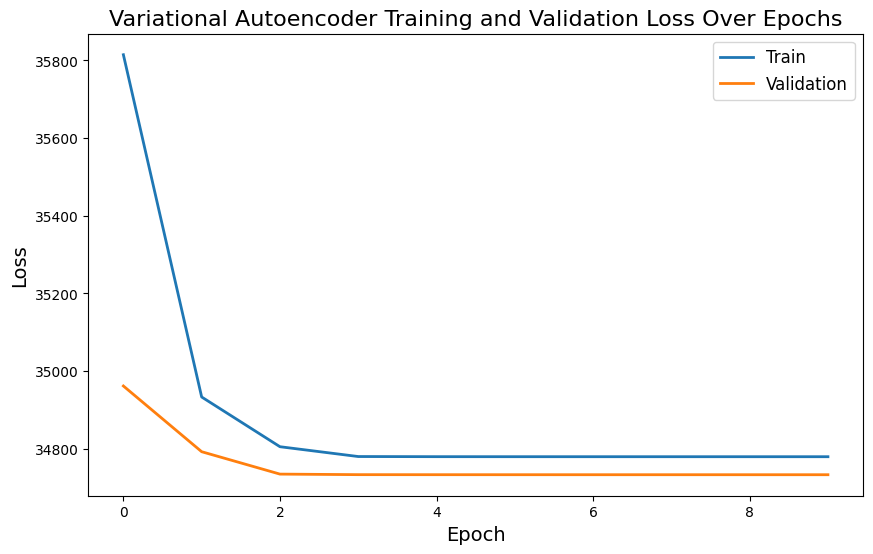

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(tr_loss_history_cpu, label="Train", linewidth=2)
plt.plot(va_loss_history_cpu, label="Validation", linewidth=2)
plt.title('Variational Autoencoder Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

## Test the model on the test set (and Plot)

Average Test Loss: 34737.6303


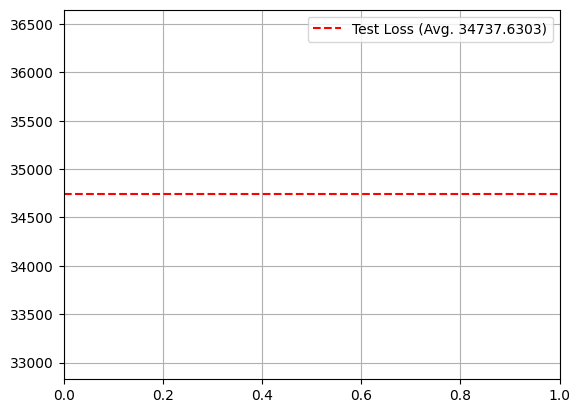

In [13]:
# Test the VAE model on the test set
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in Ts_dataloader:
        inputs = inputs.to(device)
        outputs, mu, logvar = model(inputs)
        loss = criterion(outputs, inputs, mu, logvar)
        test_loss += loss.item() * inputs.size(0)

average_test_loss = test_loss / len(Ts_dataloader.dataset)
print('Average Test Loss: {:.4f}'.format(average_test_loss))

# Plot the test loss as a horizontal line for comparison
plt.axhline(y=average_test_loss, color='r', linestyle='--', label="Test Loss (Avg. {:.4f})".format(average_test_loss))

# Display the plot
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()